In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from get_decision_variable_map import get_decision_variable_map

In [2]:
case_names = [    
              "Thermal_Base",
              # "2_Hr_BESS", 
              # "2_Hr_BESS_Fuelx2",
              # "4_Hr_BESS",
              # "4_Hr_BESS_Fuelx2",
              # "4_Hr_BESS_Fuelx3",
              # "4_Hr_BESS_Fuelx4",
              # "6_Hr_BESS",
              # "6_Hr_BESS_Fuelx2",
            #   "8_Hr_BESS",
            #   "8_Hr_BESS_Fuelx2",
            #   "10_Hr_BESS",
            #   "10_Hr_BESS_Fuelx2",
              ]

In [3]:
import os

current_dir = os.getcwd()
print(current_dir)

c:\Users\ks885\Documents\aa_research\Modeling\spcm_genx_experiment\figures


In [4]:
plots_path = os.path.join(current_dir, 'plots') + "/"
tables_path = os.path.join(current_dir, 'tables') + "/"

In [5]:
# modeling scaling ModelScalingFactor
ModelScalingFactor = 1000

cem_path = os.path.join(os.path.dirname(current_dir), 'GenX.jl', 'research_systems')
policies_path = os.path.join(os.path.dirname(current_dir), 'SPCM', 'research_systems')



In [6]:
model_types = [
                # 'cem',
                'pf',
                'dlac-p',
                'dlac-i',
                'slac',
]

In [7]:
# Create a DataFrame with decision_variable_names as the index
decision_variable_map = get_decision_variable_map()

In [8]:
# get load data

load_data_raw = pd.read_csv(cem_path + '\\Thermal_Base\\' + 'system\\' + 'Demand_data.csv')
load_data = load_data_raw['Demand_MW_z1']

In [9]:
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

In [10]:
def process_decision_variable(decision_variable_name, model_types_list, cem_results_path):
    # Get the corresponding file names from the decision_variable_map
    cem_file_name = decision_variable_map.loc[decision_variable_name, 'CEM']
    policies_file_name = decision_variable_map.loc[decision_variable_name, 'Policies']
    
    if cem_file_name is None or policies_file_name is None:
        raise ValueError(f"File names for decision variable '{decision_variable_name}' are not defined in the map.")
    
    # Read and process CEM data
    cem_file_path = os.path.join(cem_results_path, cem_file_name + '.csv')
    cem_data = pd.read_csv(cem_file_path, header=None)
    cem_data = cem_data.iloc[2:]  # Remove the first two rows
    cem_data.reset_index(drop=True, inplace=True)
    
    # Read and process Policies data for each model type
    policies_data_dict = {}
    for model_type in model_types_list:
        policies_results_path = os.path.join(policies_path, f'results_{model_type}')
        policies_file_path = os.path.join(policies_results_path, policies_file_name + '.csv')
        policies_data = pd.read_csv(policies_file_path, header=None)
        policies_data = policies_data.transpose()  # Transpose the dataframe
        policies_data_dict[model_type] = policies_data
    
    return cem_data, policies_data_dict

In [11]:
decision_variable_name = 'energy prices'
# model_types_list = ['pf', 'dlac-p', 'dlac-i', 'slac']
# model_types_list = ['pf','dlac-p', 'slac']
# model_types_list = ['pf']
model_types_list = ['dlac-p']
string_of_model_types = "_".join(model_types_list)

case_name = case_names[0]



In [12]:
# Plotting Timeseries
# start_time = 500
# fractional_time = 0.015
fractional_time = 0.2
# end_time = start_time + min(round(fractional_time * len(load_data) - 1),8685)
# time_period = [start_time, end_time]
time_periods = [
    [int(i), int(min(i + round(fractional_time * len(load_data)) - 1, len(load_data) - 1))]
    for i in range(0, len(load_data), round(fractional_time * len(load_data)))
]

In [13]:
time_periods

[[0, 1736],
 [1737, 3473],
 [3474, 5210],
 [5211, 6947],
 [6948, 8684],
 [8685, 8685]]

In [14]:
def get_case_outputs_all_models(cem_path, policies_path, case_name, decision_variable_name, model_types_list):
    cem_results_path = os.path.join(cem_path, case_name, 'results')

    # Get the corresponding file names from the decision_variable_map
    cem_output_name = decision_variable_map.loc[decision_variable_name, 'CEM']
    policies_file_name = decision_variable_map.loc[decision_variable_name, 'Policies']

    if cem_output_name is None or policies_file_name is None:
        raise ValueError(f"File names for decision variable '{decision_variable_name}' are not defined in the map.")

    # Read and process CEM data
    cem_file_path = os.path.join(cem_results_path, cem_output_name + '.csv')
    cem_data_raw = pd.read_csv(cem_file_path)
    # if 'Zone' and 'AnnualSum' are in the first rows of the first column then remove the first two rows
    if 'Resource' in cem_data_raw.iloc[:,1] and 'Zone' in cem_data_raw.iloc[:, 1] \
                and 'AnnualSum' in cem_data_raw.iloc[:, 1]:
        cem_data = cem_data_raw.drop([1, 2])  # Remove the first two rows
    elif 'Segment' in cem_data_raw.iloc[:, 1] and 'Zone' in cem_data_raw.iloc[:, 1] \
                and 'AnnualSum' in cem_data_raw.iloc[:, 1]:
        # Remove the second and third rows
        cem_data = cem_data_raw.drop([1, 2])
    elif 'Resource' in cem_data_raw.iloc[:,1] and 'Zone' in cem_data_raw.iloc[:, 1]:
        cem_data = cem_data_raw.drop([1])  # Remove the first row
    else:
        cem_data = cem_data_raw

    cem_data.reset_index(drop=True, inplace=True)

    # Read and process Policies data for each model type
    policies_data_dict = {}
    for model_type in model_types_list:
        policies_results_path = os.path.join(policies_path, case_name, f'results_{model_type}')
        policies_file_path = os.path.join(policies_results_path, policies_file_name + '.csv')
        policies_data = pd.read_csv(policies_file_path)
        # if shape of policies_dadta is has more columns than rows, transpose it
        if policies_data.shape[0] < policies_data.shape[1]:
            policies_data = policies_data.transpose()  # Transpose the dataframe
        else:
            # if shape of policies_data is has more rows than columns, dont transpose?
            pass
        # Add the resource names to the policies data
        # policies_data.columns = resource_list
        policies_data_dict[model_type] = policies_data

    # find the names of columns that are in both cem_data and policies_data
    columns_2_print = list(set(cem_data.columns).intersection(set(policies_data_dict[model_types_list[0]].columns)))

    return cem_data, policies_data_dict, columns_2_print

In [15]:
cem_data, policies_data_dict, columns_2_print = get_case_outputs_all_models(cem_path, policies_path, case_name, decision_variable_name, model_types_list)

In [16]:
cem_results_path = os.path.join(cem_path, case_name, 'results')

# Get the name of the resources in this case from the cem results path
capacity_file_path = os.path.join(cem_results_path, 'capacity.csv')
capacity_data = pd.read_csv(capacity_file_path)
resource_list = capacity_data.loc[capacity_data['EndCap'] != 0, 'Resource']
resource_list = resource_list[resource_list != 'Total']
zone_list = ["1"]

In [17]:
cem_data

,Zone,1
0,t1,35.224140
1,t2,35.224140
2,t3,35.224140
3,t4,35.224140
4,t5,35.224140
...,...,...
8681,t8682,68.806217
8682,t8683,35.224140
8683,t8684,35.224140
8684,t8685,26.981421


In [18]:
columns_2_print

['1']

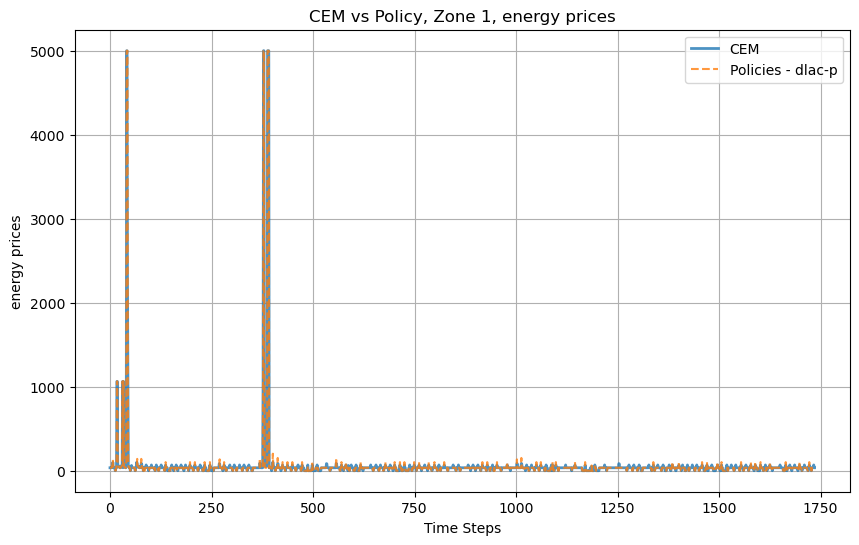

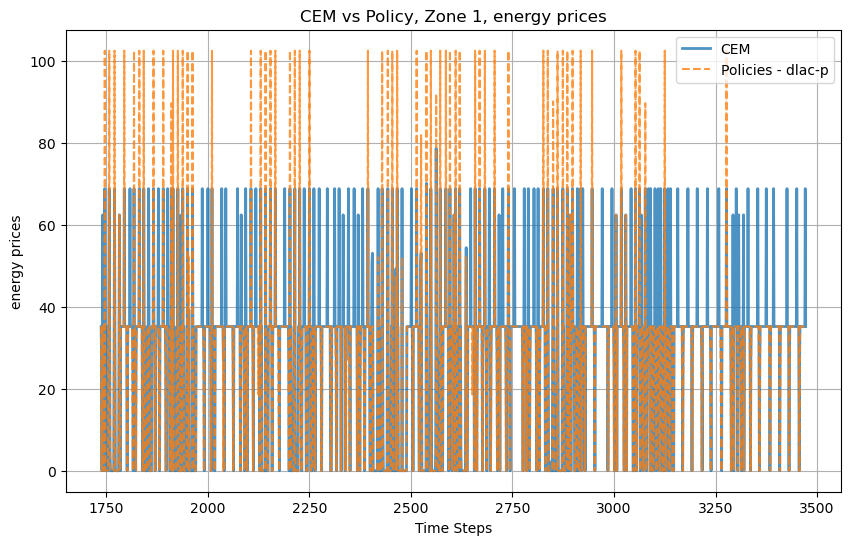

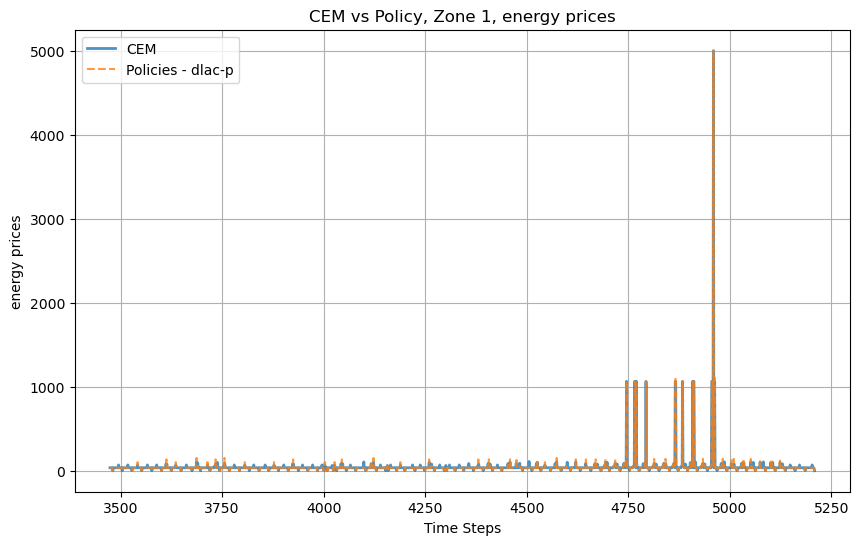

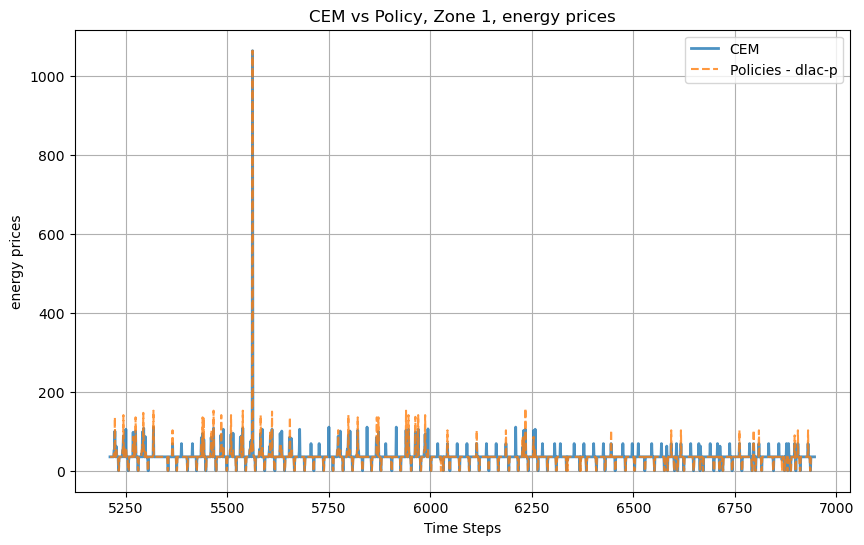

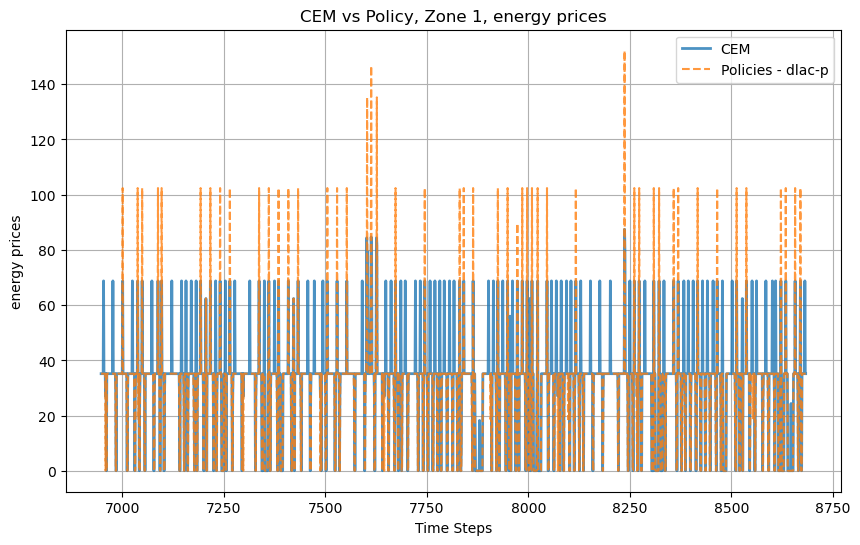

In [ ]:
'''
inputs:
    cem_data: DataFrame containing CEM data
    policies_data_dict: Dictionary containing Policies data for each model type
    resource: The resource to plot
    time_period: The time period to plot
    filename: The name of the file to save the plot
    model_types_list: List of model types to plot
    decision_variable_name: The decision variable name to plot
    plots_path: The path to save the plots

outputs:
    A PDF file containing the plots for the selected resource and time period
'''



if decision_variable_name == 'non-served energy' or decision_variable_name == 'energy prices':
    column_names = zone_list
else:
    column_names = resource_list

column_name = column_names[0]

filename = 'figX_' + case_name + '_' + decision_variable_name + '_' \
                    + column_name + '_' + string_of_model_types + '_' + date + '.pdf'


# Create a PDF to save the plots
with PdfPages(os.path.join(plots_path, filename)) as pdf:
    for time_period in time_periods:
        # modeling scaling ModelScalingFactor
        ModelScalingFactor = 1000

        # print(resource)
        plt.figure(figsize=(10, 6))
        
        # Plot CEM data for the selected time period
        plt.plot(cem_data.index[time_period[0]:time_period[1]], 
                    cem_data[column_name][time_period[0]:time_period[1]], 
                    label='CEM', linewidth=2, alpha=0.8)
        
        # Plot Policies data for each model type for the selected time period
        for model_type, policies_data in policies_data_dict.items():
            plt.plot(policies_data.index[time_period[0]:time_period[1]], 
                        policies_data[column_name][time_period[0]:time_period[1]], 
                        label=f'Policies - {model_type}', linestyle='--', alpha=0.8)
        
        # Add labels, title, and legend
        plt.xlabel('Time Steps')
        plt.ylabel(f'{decision_variable_name}')
        plt.title(f'CEM vs Policy, Zone {column_name}, {decision_variable_name}')
        plt.legend()
        plt.grid(True)
        
        # Save the plot to the PDF
        pdf.savefig()
    plt.close()